# Quantum Supremacy Demonstration by Employing a Pulse-Based Variational Quantum Algorithm to Tackle a Large Optimization Problem - Draft 5

Ohad Lev

June 2024

-----------

The original QEMC algorithm's cost function:

$$
    C_1 \big( E, P, B \big) = \sum_{(i, j) \in E}
    \bigg(p_i + p_j - \frac{1}{|B|} \bigg)^2 +
    \bigg(\big|p_i - p_j\big| - \frac{1}{|B|} \bigg)^2
    \tag{1}
$$

Where:

* $E$ is the set of edges of the undirected, unweighted graph $G = (V, E)$ ($V$ is the set of nodes).
* $P$ is the probability distribution reconstructed from multiple executions and measurements of the QEMC'S Ansatz circuit.
* $p_i, p_j$ are the probabilites in $P$ associated with the nodes $v_i, v_j \in V$.
* $B \subset V$ is the set of "blue" nodes.

**A major issue: the cost function $C_1$ is designed for the situation where $B \approx |V|\ /\ 2$, as explained in** *Draft 4*. But we are interested in the particular situation where the following conditions hold:

<div class="alert alert-block alert-success">
    <b>Box 1: Conditions Needed to be Hold</b>
    <br /><br />
    1. $|B| << |V|$. <br />
    2. $|V|$ is large ($|V| > 2^{60}$). <br />
    3. $\text{Var}\big(D\big)$ is large, where $D$ is the degree distribution of the graph nodes ($|D| = |V|$). <br />
    <br />
    In other words, it means that we are intersted in large graphs, which are sparse and manifest high varaince in their nodes' degree.
</div>

## The Degree Heuristic

If the the $3$ conditions in **Box 1** hold, it is plausible to assume that there is a strong correlation between the degree of given node to its contribution to the cut - the higher the degree, it is more probable that the node is "blue". If it's true, it should turn the problem easy to approximate, since we can obtain a good approximation in linear time, simply by iterating over all nodes and choosing the $|B|$ nodes with the highest degree. It seems disturbing for our cause, but in fact when we look carefully at the $3$ conditions depicted in **Box 1** - we see that the problem stays exponentially hard, since we deal with exponentially large graphs, by definition.

Anyway, it can be useful to verify our inutition with respect to tractable-size graphs, but where conditions $1$ + $3$ hold:

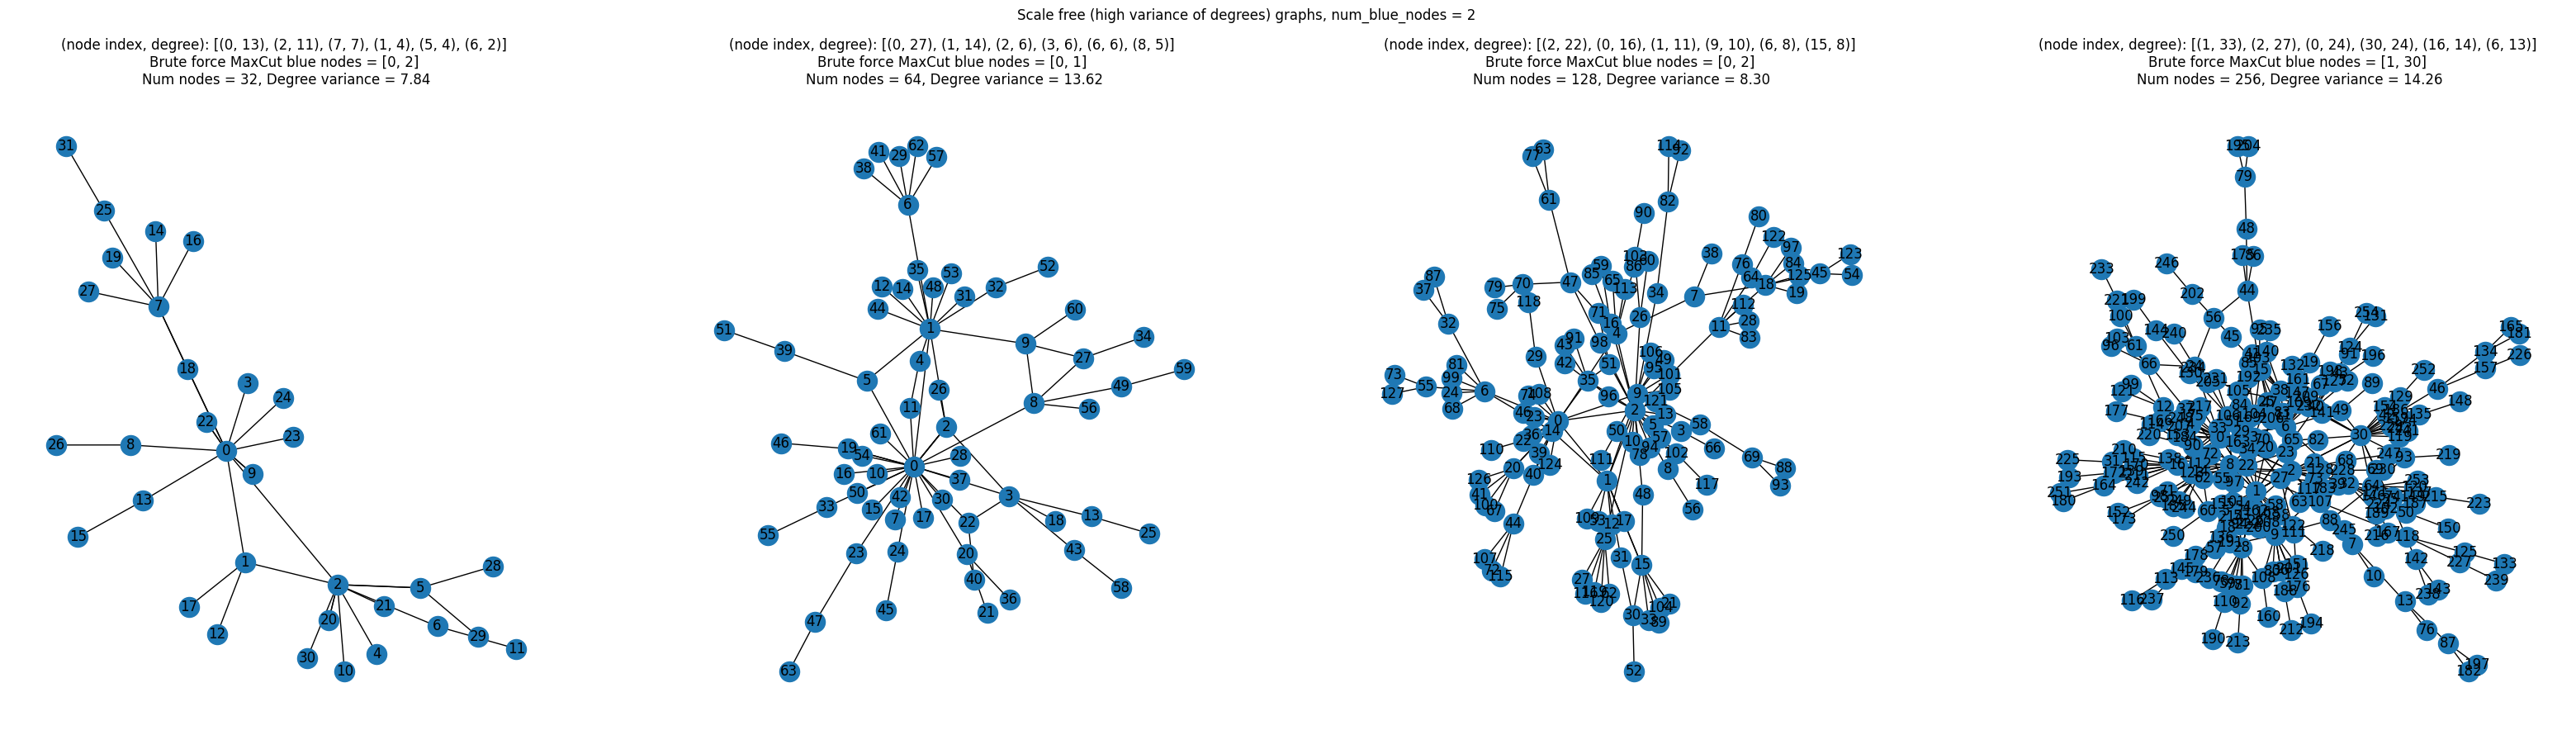

In [14]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from draft_5_util_funs import brute_force_maxcut_efficient_ver2


def obtain_high_degree_variance_graph(num_nodes) -> nx.Graph:
    graph = nx.scale_free_graph(
        n=num_nodes,
        seed=np.random.randint(100),
        alpha=0.4,
        beta=0.2,
        gamma=0.4
    ).to_undirected()
    
    graph.remove_edges_from(nx.selfloop_edges(graph))
    
    return graph

    
num_nodes_list = [32, 64, 128, 256]
num_blue_nodes = 2

fig, axes = plt.subplots(1, 4, figsize=(40, 10))
fig.suptitle(f"Scale free (high variance of degrees) graphs, num_blue_nodes = {num_blue_nodes}")

graphs = {}
for index, num_nodes in enumerate(num_nodes_list):

    graph = obtain_high_degree_variance_graph(num_nodes)
    graphs[num_nodes] = graph
    nx.draw(graph, with_labels=True, ax=axes[index])
    
    highest_degree_nodes = sorted(
        graph.degree,
        key=lambda item: item[1],
        reverse=True
    )[:num_blue_nodes * 3]
    
    maxcut_res = brute_force_maxcut_efficient_ver2(
        graph=graph,
        num_blue_nodes=num_blue_nodes
    )
    maxcut_blue_nodes = [
        index for index, char in enumerate(maxcut_res["best_partition"]) if char == "1"
    ]
    
    degree_variance = np.array(list(dict(graph.degree).values())).var()
    
    axes[index].set_title(
        f"(node index, degree): {highest_degree_nodes} \n" \
        f"Brute force MaxCut blue nodes = {maxcut_blue_nodes} \n" \
        f"Num nodes = {num_nodes}, Degree variance = {degree_variance:.2f}"
    )

Indeed, the figure above verifies our intuition - there is a (very) strong correlation between a node's degree to its association when dealing with $(|B|, |V| - |B|)$-**MaxCut** under the conditions stated above.

## Modified Cost Function

We can exploit the unique conditions of the problem setting we have defined in **Box 1** + the verified [degree heursitic](#The-Degree-Heuristic) to our favour. In the discussed specific terms, what we want the optimization process to obtain is not only separation between "blue" and "red" nodes, but approximately equivalently, a separation between high- to low-degree nodes.

Hence, consider the following cost function:

$$
    C_2 \big( E, P, B, D \big) = \sum_{(i, j) \in E}
    \Bigg[ \big(d_i - d_j\big)^2 \Bigg] \Bigg[
        \bigg(p_i + p_j - \frac{1}{|B|} \bigg)^2 +
        \bigg(\big|p_i - p_j\big| - \frac{1}{|B|} \bigg)^2
    \Bigg]
    \tag{2}
$$

Where:

* $d_i, d_j$ are the degrees of the nodes $v_i, v_j$.
* We denote the term in the first square brackets as the "*degrees prefactor*".
* We denote the term in the second square brackets as the "*adjacency cost*" (same term as in $C_1$).

When two adjacent nodes' degrees are significantly different:

* The nodes are probably of different subsets, and if not - it is still can be approximately "good" to associate them into two different subsets.
* Their *degrees prefactor* is relatively large, by definition.
* To minimize the cost function, an optimizer should try to minimize their *adjacency cost* - much more "eagerly" than the opposite case when the *degrees prefactor* is small.

In other words, while the *adjacency cost* on its own still suffers from incompatibility to the conditions depicted in **Box 1**, the multiplication (per edge) with the *degrees prefactor* should drive the optimization process towards a parameterization that drives the *adjacency cost* term to $0$ for the edges we are intersted in - thereby we achive some kind of "probability amplification" towards the desired state, where we have $|B|$ probabilities amplified to $1/|B|$ and the rest probabilities deamplified to $0$.

### Modified Cost Function - Numerical Analysis

In [21]:
# Adding graphs
additional_graph_sizes = [512, 1_024, 2_048]
for num_nodes in additional_graph_sizes:
    graphs[num_nodes] = obtain_high_degree_variance_graph(num_nodes)

In [32]:
from pathlib import Path
from qiskit_aer import StatevectorSimulator
from draft_5_util_funs import QEMC, qemc_c2, qemc_c4
from draft_4_util_funs import qemc_cost_fun

maxiter = 1_000

num_blue_nodes_list = [2, 4, 8, 16, 32]
optimization_funs = [qemc_cost_fun, qemc_c2, qemc_c4]

results = {}
for num_nodes, graph in graphs.items():
    results[f"num_nodes_{num_nodes}"] = {}
    
    for num_blue_nodes in num_blue_nodes_list:
        results[f"num_nodes_{num_nodes}"][f"num_blue_nodes_{num_blue_nodes}"] = {}
        
        qemc_executer = QEMC(
            graph=graph,
            num_blue_nodes=num_blue_nodes,
            quantum_backend=StatevectorSimulator()
        )

        ansatz = qemc_executer.define_ansatz()

        for optimization_fun in optimization_funs:

            print()
            print(
                f"Executing QEMC with: num_nodes={num_nodes}, num_blue_nodes={num_blue_nodes}," \
                f"cost_function={optimization_fun.__name__}"
            )

            qemc_result = qemc_executer.run(
                optimization_fun=optimization_fun,
                optimization_method="COBYLA",
                optimization_options={"maxiter": maxiter}
            )

            export_path = Path("/home/ohadlev77/personal/research/large_scale_variational_quantum_optimization/draft_5_data")
            QEMC.export_qemc_result_data(qemc_result, export_path)
            results[f"num_nodes_{num_nodes}"][f"num_blue_nodes_{num_blue_nodes}"][
                f"optimization_fun_{optimization_fun}"
            ] = qemc_result

            print(
                f"DONE. final_cut_value={qemc_result['data']['cut_values'][-1]}"
            )

# # print(brute_force_maxcut_efficient_ver2(graph, num_blue_nodes=num_blue_nodes))


Executing QEMC with: num_nodes=32, num_blue_nodes=2,cost_function=qemc_cost_fun
DONE. final_cut_value=22

Executing QEMC with: num_nodes=32, num_blue_nodes=2,cost_function=qemc_c2
DONE. final_cut_value=22

Executing QEMC with: num_nodes=32, num_blue_nodes=2,cost_function=qemc_c4
DONE. final_cut_value=22

Executing QEMC with: num_nodes=32, num_blue_nodes=4,cost_function=qemc_cost_fun
DONE. final_cut_value=27

Executing QEMC with: num_nodes=32, num_blue_nodes=4,cost_function=qemc_c2
DONE. final_cut_value=28

Executing QEMC with: num_nodes=32, num_blue_nodes=4,cost_function=qemc_c4
DONE. final_cut_value=28

Executing QEMC with: num_nodes=32, num_blue_nodes=8,cost_function=qemc_cost_fun
DONE. final_cut_value=29

Executing QEMC with: num_nodes=32, num_blue_nodes=8,cost_function=qemc_c2
DONE. final_cut_value=28

Executing QEMC with: num_nodes=32, num_blue_nodes=8,cost_function=qemc_c4
DONE. final_cut_value=29

Executing QEMC with: num_nodes=32, num_blue_nodes=16,cost_function=qemc_cost_fun


DONE. final_cut_value=212

Executing QEMC with: num_nodes=1024, num_blue_nodes=4,cost_function=qemc_c4
DONE. final_cut_value=257

Executing QEMC with: num_nodes=1024, num_blue_nodes=8,cost_function=qemc_cost_fun
DONE. final_cut_value=322

Executing QEMC with: num_nodes=1024, num_blue_nodes=8,cost_function=qemc_c2
DONE. final_cut_value=250

Executing QEMC with: num_nodes=1024, num_blue_nodes=8,cost_function=qemc_c4
DONE. final_cut_value=290

Executing QEMC with: num_nodes=1024, num_blue_nodes=16,cost_function=qemc_cost_fun
DONE. final_cut_value=404

Executing QEMC with: num_nodes=1024, num_blue_nodes=16,cost_function=qemc_c2
DONE. final_cut_value=334

Executing QEMC with: num_nodes=1024, num_blue_nodes=16,cost_function=qemc_c4
DONE. final_cut_value=417

Executing QEMC with: num_nodes=1024, num_blue_nodes=32,cost_function=qemc_cost_fun
DONE. final_cut_value=483

Executing QEMC with: num_nodes=1024, num_blue_nodes=32,cost_function=qemc_c2
DONE. final_cut_value=309

Executing QEMC with: nu

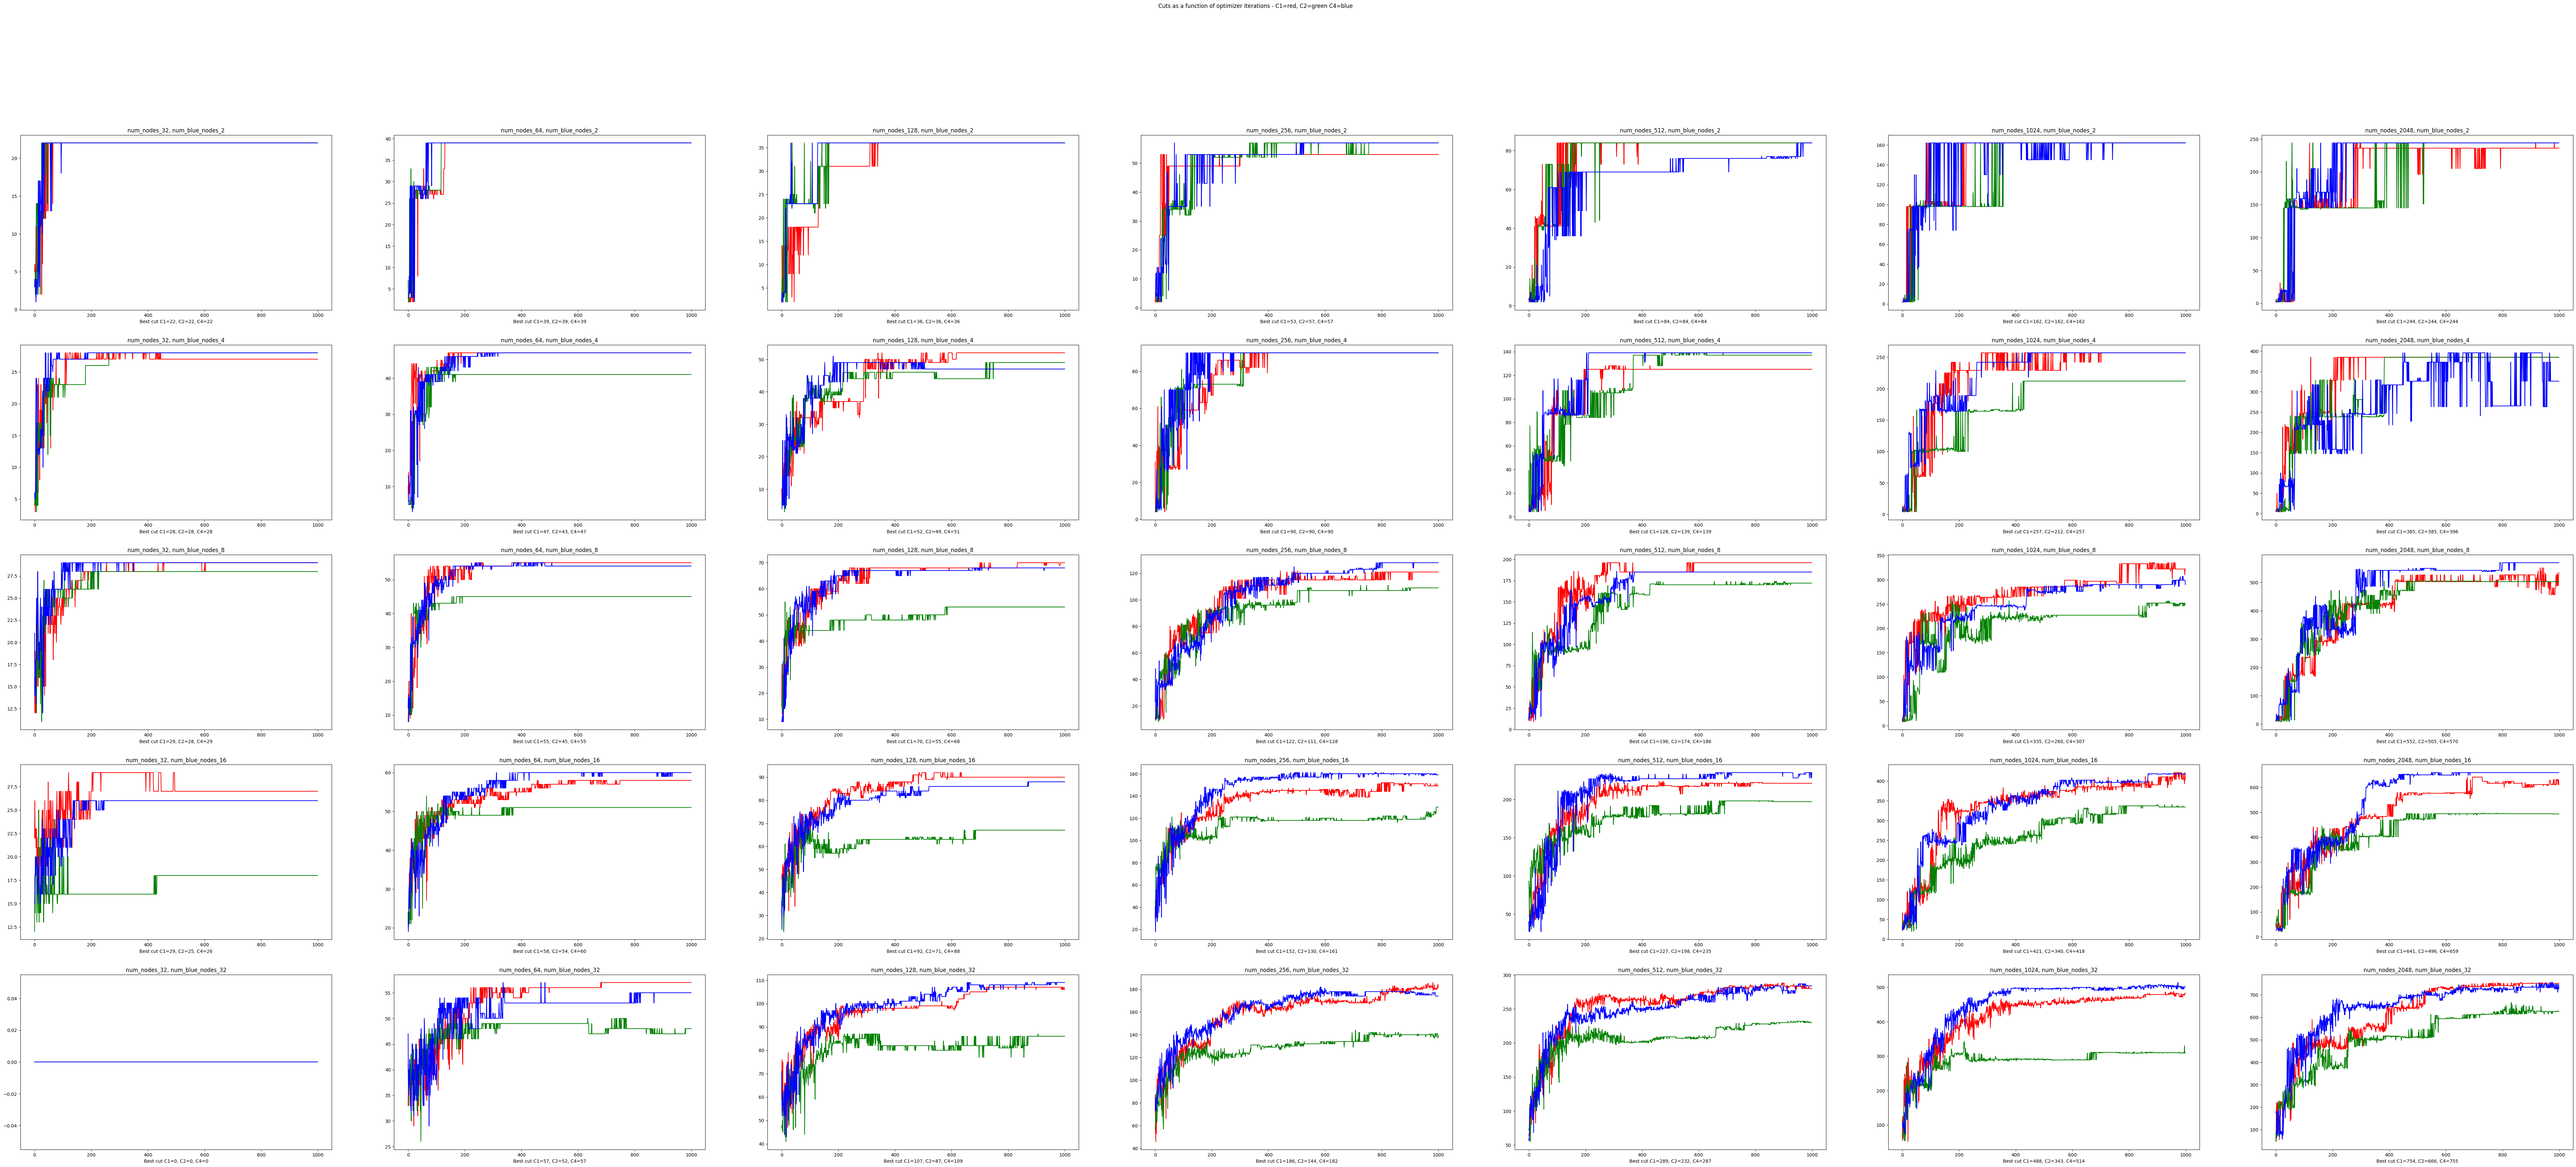

In [42]:
fig, axes = plt.subplots(5, 7, figsize=(100, 40))

fig.suptitle("Cuts as a function of optimizer iterations - C1=red, C2=green C4=blue")

x_axis = range(1000)
opt_fun_colors = ["red", "green", "blue"]

for col_index, (k1, v1) in enumerate(results.items()):
    for row_index, (k2, v2) in enumerate(v1.items()):
        
        cell = axes[row_index][col_index]
        cell.set_title(f"{k1}, {k2}")
        
        best_cuts = []
        for opt_fun_index, (k3, v3) in enumerate(v2.items()):
            cell.plot(x_axis, v3["data"]["cut_values"], color=opt_fun_colors[opt_fun_index])
            best_cuts.append(max(v3["data"]["cut_values"]))
            
        cell.set_xlabel(f"Best cut C1={best_cuts[0]}, C2={best_cuts[1]}, C4={best_cuts[2]}")